<a href="https://colab.research.google.com/github/Yuchen-PLB/ECS171-FP/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import pandas as pd
!pip install pca
from pca import pca
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7096 sha256=e73a55a9d4472d1b50ea93e5603eb6138edd3efb61ede9bd3b1d2008a38b4f71
  Stored in directory: /root/.cache/pip/wheels/06/b2/e0/b239bd2c0ff89b98c4f0c86a63e7059f38a8dfaf6df2641c63
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=7615eb8c9f743929ada55c244a4ebdd8efb1045cad37acbcc520e381d18dd611
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built adjustText wget


#3.3.1 Prepare the Data

In [3]:
# read in the dataset locally
chip_dataset = pd.read_csv('/content/chip_dataset.csv')

# drop the first column which list all the indices
chip_dataset.drop('Unnamed: 0', inplace=True, axis=1)

chip_dataset

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,NVIDIA Quadro 3000M,GPU,2011-02-22,40.0,75.0,332.0,1950.0,450.0,TSMC,NVIDIA,NaN,432.0,36.0
4850,Intel GMA 950,GPU,2005-06-01,90.0,7.0,NaN,NaN,250.0,Intel,Intel,NaN,NaN,NaN
4851,NVIDIA GeForce GT 320M,GPU,2010-03-03,40.0,23.0,100.0,486.0,500.0,TSMC,NVIDIA,NaN,52.8,NaN
4852,NVIDIA GeForce FX 5200,GPU,2003-03-06,150.0,NaN,65.0,29.0,250.0,TSMC,NVIDIA,NaN,NaN,NaN


In [4]:
# transform categorical feature 'Release Date' to numerical value
for i in range(len(chip_dataset['Release Date'])):
  if 'Na' in chip_dataset.iat[i, 2] :
    chip_dataset.iat[i, 2] = np.NaN
  else:
    year = int(chip_dataset.iat[i, 2][0:4])-2000
    month = int(chip_dataset.iat[i, 2][5:7])/12
    day = int(chip_dataset.iat[i, 2][8:10])/365
    chip_dataset.iat[i, 2] = year+ month + day

In [5]:
# split the data to CPU and GPU subsets
grouped = chip_dataset.groupby(chip_dataset['Type'])

# spilt and get the CPU dataset
CPU = grouped.get_group('CPU')
del CPU['FP16 GFLOPS']
del CPU['FP32 GFLOPS']
del CPU['FP64 GFLOPS']

# split and get the GPU dataset
GPU = grouped.get_group('GPU')

In [6]:
# data normalization for CPU dataset
from sklearn.preprocessing import MinMaxScaler
CPU_normal = CPU.copy().drop(columns=['Product','Type','Foundry','Vendor'])
scaler = MinMaxScaler()
scaler.fit(CPU_normal)
fit = scaler.fit_transform(CPU_normal)
# fit = pd.DataFrame(fit, columns = CPU_normal.columns)
final = pd.DataFrame(data = fit, columns = CPU_normal.columns, index = CPU_normal.index)
CPU_normal = CPU.copy().drop(columns=CPU_normal.columns).join(final)
CPU_normal

,Product,Type,Foundry,Vendor,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
0,AMD Athlon 64 3500+,CPU,Unknown,AMD,0.321634,0.335260,0.110276,0.111274,0.004436,0.390244
1,AMD Athlon 200GE,CPU,Unknown,AMD,0.875211,0.040462,0.085213,0.279649,0.248552,0.634146
2,Intel Core i5-1145G7,CPU,Intel,Intel,0.970584,0.017341,0.067669,NaN,NaN,0.487805
3,Intel Xeon E5-2603 v2,CPU,Intel,Intel,0.634806,0.086705,0.197995,0.232796,0.071127,0.292683
4,AMD Phenom II X4 980 BE,CPU,Unknown,AMD,0.523187,0.219653,0.310777,0.376281,0.037625,0.756098
...,...,...,...,...,...,...,...,...,...,...
2187,Intel Xeon Gold 6312U,CPU,Intel,Intel,0.999080,0.017341,0.461153,NaN,NaN,0.439024
2188,AMD Ryzen 9 4900H,CPU,TSMC,AMD,0.948449,0.000000,0.132832,0.226940,0.509471,0.658537
2189,Intel Core 2 Duo E6550,CPU,Intel,Intel,0.339117,0.335260,0.160401,0.207906,0.013255,0.422683
2190,AMD Opteron 246,CPU,Unknown,AMD,0.215248,0.479769,0.210526,NaN,0.003601,0.341463


In [7]:
#data normalization for GPU dataset
from sklearn.preprocessing import MinMaxScaler
GPU_normal = GPU.copy().drop(columns=['Product','Type','Foundry','Vendor'])
scaler = MinMaxScaler()
scaler.fit(GPU_normal)
fit = scaler.fit_transform(GPU_normal)

#add back to the dataframe
final = pd.DataFrame(data = fit, columns = GPU_normal.columns, index = GPU_normal.index)
#GPU_normal = GPU.copy().drop(columns=GPU_normal.columns).join(final)
GPU_normal

,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
2192,11.341553,32.0,95.0,216.0,1160.0,100.0,NaN,NaN,NaN
2193,2.568493,150.0,NaN,174.0,80.0,200.0,NaN,NaN,NaN
2194,19.22968,14.0,25.0,132.0,3300.0,1469.0,18.38,1177.0,36.77
2195,8.255479,130.0,NaN,NaN,NaN,200.0,NaN,12.8,NaN
2196,8.832192,55.0,20.0,73.0,242.0,600.0,NaN,96.0,NaN
...,...,...,...,...,...,...,...,...,...
4849,11.226941,40.0,75.0,332.0,1950.0,450.0,NaN,432.0,36.00
4850,5.50274,90.0,7.0,NaN,NaN,250.0,NaN,NaN,NaN
4851,10.258219,40.0,23.0,100.0,486.0,500.0,NaN,52.8,NaN
4852,3.266438,150.0,NaN,65.0,29.0,250.0,NaN,NaN,NaN


In [8]:
# encode the categorical features
CPU['Vendor'] = CPU['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])
GPU['Vendor'] = GPU['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], ['0', '1','2','3','4'])

<ipython-input-8-ab1b57c62c2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPU['Vendor'] = CPU['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])
<ipython-input-8-ab1b57c62c2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPU['Vendor'] = GPU['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], ['0', '1','2','3','4'])


In [9]:
# drop NaN rows

#Here we will use y= number of transistors and x to be other variable
CPU_normal = CPU_normal.dropna()
#CPU.drop('Transistor')
X = CPU_normal. iloc[:, [4,5,6,7,9]]
y = CPU_normal. iloc[:, [8]]

X.head()

,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Freq (MHz)
0,0.321634,0.335260,0.110276,0.111274,0.390244
1,0.875211,0.040462,0.085213,0.279649,0.634146
3,0.634806,0.086705,0.197995,0.232796,0.292683
4,0.523187,0.219653,0.310777,0.376281,0.756098
5,0.634806,0.086705,0.235589,0.232796,0.439024


In [10]:
CPU_normal['Vendor'] = CPU_normal['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])
#GPU_normal['Vendor'] = GPU_normal['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], ['0', '1','2','3','4'])
CPU_p = CPU_normal.iloc[:,[3,4,5,6,7,8,9]]
CPU_p.head()

<ipython-input-10-eb89b142d344>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPU_normal['Vendor'] = CPU_normal['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])


,Vendor,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
0,0,0.321634,0.335260,0.110276,0.111274,0.004436,0.390244
1,0,0.875211,0.040462,0.085213,0.279649,0.248552,0.634146
3,1,0.634806,0.086705,0.197995,0.232796,0.071127,0.292683
4,0,0.523187,0.219653,0.310777,0.376281,0.037625,0.756098
5,1,0.634806,0.086705,0.235589,0.232796,0.071127,0.439024


In [11]:
CPU['Vendor'] = CPU['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])
#GPU_normal['Vendor'] = GPU_normal['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], ['0', '1','2','3','4'])
CPU_w = CPU.iloc[:,[0,2,3,4,5,6,7,8,9]]
CPU_w = CPU_w.dropna()
display(CPU_w)
CPU_p = CPU_w.iloc[:,[1,2,3,4,5,6,8]]

<ipython-input-11-09a95eeaccb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPU['Vendor'] = CPU['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])


,Product,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
0,AMD Athlon 64 3500+,7.221461,65.0,45.0,77.0,122.0,2200.0,Unknown,0
1,AMD Athlon 200GE,18.766438,14.0,35.0,192.0,4800.0,3200.0,Unknown,0
3,Intel Xeon E5-2603 v2,13.75274,22.0,80.0,160.0,1400.0,1800.0,Intel,1
4,AMD Phenom II X4 980 BE,11.424886,45.0,125.0,258.0,758.0,3700.0,Unknown,0
5,Intel Xeon E5-2470 v2,13.75274,22.0,95.0,160.0,1400.0,2400.0,Intel,1
...,...,...,...,...,...,...,...,...,...
2180,AMD EPYC 7262,19.685845,7.0,155.0,74.0,3800.0,3100.0,TSMC,0
2182,AMD Athlon XP 2600+ DTR,1.086073,130.0,68.0,101.0,63.0,1917.0,Unknown,0
2188,AMD Ryzen 9 4900H,20.293836,7.0,54.0,156.0,9800.0,3300.0,TSMC,0
2189,Intel Core 2 Duo E6550,7.586073,65.0,65.0,143.0,291.0,2333.0,Intel,1


#3.3.2 Linkage Graphic Visualization

,Process Size (nm),Die Size (mm^2),Transistors (million),Freq (MHz)
0,65.0,77.0,122.0,2200.0
1,14.0,192.0,4800.0,3200.0
3,22.0,160.0,1400.0,1800.0
4,45.0,258.0,758.0,3700.0
5,22.0,160.0,1400.0,2400.0


array([[1.06100000e+03, 1.25900000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.32300000e+03, 1.54300000e+03, 0.00000000e+00, 3.00000000e+00],
       [1.00000000e+00, 3.50000000e+01, 0.00000000e+00, 2.00000000e+00],
       ...,
       [3.07900000e+03, 3.08100000e+03, 4.10020546e+03, 1.51500000e+03],
       [3.07400000e+03, 3.08200000e+03, 8.89032652e+03, 1.53900000e+03],
       [3.05600000e+03, 3.08300000e+03, 1.81929364e+04, 1.54300000e+03]])

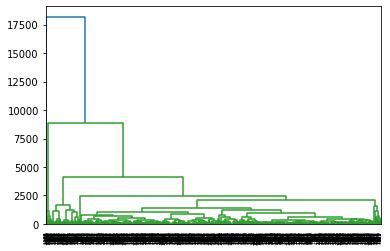

In [ ]:

CPU_p = CPU_p.iloc[:,[1,3,4,5]]
display(CPU_p.head())
linkage_method = linkage(CPU_p, method ='average', metric='euclidean')
Dendrogram = dendrogram(linkage_method)
linkage_method

In [ ]:
CPU_p

,Process Size (nm),Die Size (mm^2),Transistors (million),Freq (MHz)
0,65.0,77.0,122.0,2200.0
1,14.0,192.0,4800.0,3200.0
3,22.0,160.0,1400.0,1800.0
4,45.0,258.0,758.0,3700.0
5,22.0,160.0,1400.0,2400.0
...,...,...,...,...
2180,7.0,74.0,3800.0,3100.0
2182,130.0,101.0,63.0,1917.0
2188,7.0,156.0,9800.0,3300.0
2189,65.0,143.0,291.0,2333.0


In [ ]:
cluster_ea = AgglomerativeClustering(n_clusters=3, linkage='ward',affinity='euclidean')
c = cluster_ea.fit_predict(CPU_p)


In [ ]:
CPU_w['labels'] = c
x=CPU_w.loc[CPU_w['labels']==0]
y=CPU_w.loc[CPU_w['labels']==1]
z=CPU_w.loc[CPU_w['labels']==2]
a=CPU_w.loc[CPU_w['labels']==3]

true = len(x.loc[x['Vendor']==str(1)])+len(y.loc[y['Vendor']==str(0)])
accuracy = true/len(CPU_w)
display(x)
display(y)
display(z)
a

,Product,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,labels
0,AMD Athlon 64 3500+,7.221461,65.0,45.0,77.0,122.0,2200.0,Unknown,0,0
3,Intel Xeon E5-2603 v2,13.75274,22.0,80.0,160.0,1400.0,1800.0,Intel,1,0
4,AMD Phenom II X4 980 BE,11.424886,45.0,125.0,258.0,758.0,3700.0,Unknown,0,0
5,Intel Xeon E5-2470 v2,13.75274,22.0,95.0,160.0,1400.0,2400.0,Intel,1,0
6,AMD Phenom X4 9750 (125W),8.323973,65.0,125.0,285.0,450.0,2400.0,Unknown,0,0
...,...,...,...,...,...,...,...,...,...,...
2178,Intel Pentium D 820,5.4879,90.0,130.0,206.0,169.0,2800.0,Intel,1,0
2179,Intel Xeon 2.8,4.576712,90.0,135.0,135.0,155.0,2800.0,Intel,1,0
2182,AMD Athlon XP 2600+ DTR,1.086073,130.0,68.0,101.0,63.0,1917.0,Unknown,0,0
2189,Intel Core 2 Duo E6550,7.586073,65.0,65.0,143.0,291.0,2333.0,Intel,1,0


,Product,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,labels
64,AMD Ryzen 9 5900HX,21.11621,7.0,45.0,156.0,9800.0,3300.0,TSMC,0,1
90,AMD Ryzen 5 5500U,21.11621,7.0,25.0,156.0,9800.0,2100.0,TSMC,0,1
132,AMD Ryzen 5 4600U,20.099772,7.0,25.0,156.0,9800.0,2100.0,TSMC,0,1
133,AMD Ryzen Threadripper 2970WX,18.838813,12.0,250.0,213.0,19200.0,3000.0,GF,0,1
234,AMD Ryzen Threadripper 1900X,17.751598,14.0,125.0,213.0,9600.0,3800.0,GF,0,1
330,AMD Ryzen 7 4700U,20.099772,7.0,25.0,156.0,9800.0,1800.0,TSMC,0,1
502,AMD Ryzen Threadripper 1920X,17.694064,14.0,180.0,213.0,9600.0,3500.0,GF,0,1
636,AMD Ryzen Threadripper 1940,17.662785,14.0,180.0,213.0,9600.0,3200.0,GF,0,1
684,AMD Ryzen Threadripper 1950X,17.694064,14.0,180.0,213.0,9600.0,3400.0,GF,0,1
742,AMD Ryzen Threadripper 1940X,17.662785,14.0,180.0,213.0,9600.0,3500.0,GF,0,1


,Product,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,labels
1,AMD Athlon 200GE,18.766438,14.0,35.0,192.0,4800.0,3200.0,Unknown,0,2
27,AMD EPYC 7371,18.960502,14.0,170.0,213.0,4800.0,3100.0,GF,0,2
31,AMD EPYC 7501,17.579452,14.0,170.0,213.0,4800.0,2000.0,GF,0,2
35,Intel Xeon Phi 7120A,14.349772,22.0,300.0,350.0,5000.0,1238.0,Intel,1,2
48,AMD Ryzen 5 1400,17.36347,14.0,65.0,192.0,4800.0,3200.0,GF,0,2
...,...,...,...,...,...,...,...,...,...,...
2116,AMD EPYC 7352,19.685845,7.0,155.0,74.0,3800.0,2400.0,TSMC,0,2
2123,AMD Ryzen 3 3300U,19.099772,12.0,15.0,210.0,4940.0,2100.0,GF,0,2
2151,AMD EPYC 7351,17.579452,14.0,170.0,213.0,4800.0,2400.0,GF,0,2
2154,AMD Ryzen 7 2700X 50th Anniversary,19.412785,12.0,105.0,192.0,4800.0,3700.0,GF,0,2


,Product,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,labels


In [ ]:
CPU_normal['Vendor'] = CPU_normal['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])
#GPU_normal['Vendor'] = GPU_normal['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], ['0', '1','2','3','4'])
CPU_p = CPU_normal.iloc[:,[5,6,7,8,9]]
CPU_p.head()

<ipython-input-45-98bef6ae4b26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPU_normal['Vendor'] = CPU_normal['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])


,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
0,0.335260,0.110276,0.111274,0.004436,0.390244
1,0.040462,0.085213,0.279649,0.248552,0.634146
3,0.086705,0.197995,0.232796,0.071127,0.292683
4,0.219653,0.310777,0.376281,0.037625,0.756098
5,0.086705,0.235589,0.232796,0.071127,0.439024


# 3.3.3 K-Means Clustering

[pca] >n_components is set to 4
[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [1543] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [1543] unique colors! Available unique colors: [9].
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


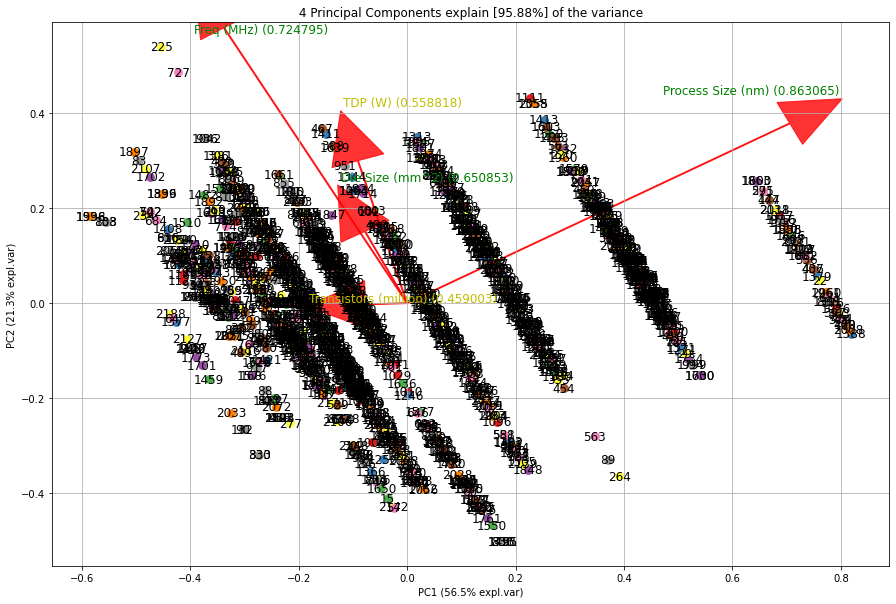

[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [1543] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [1543] unique colors! Available unique colors: [9].
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


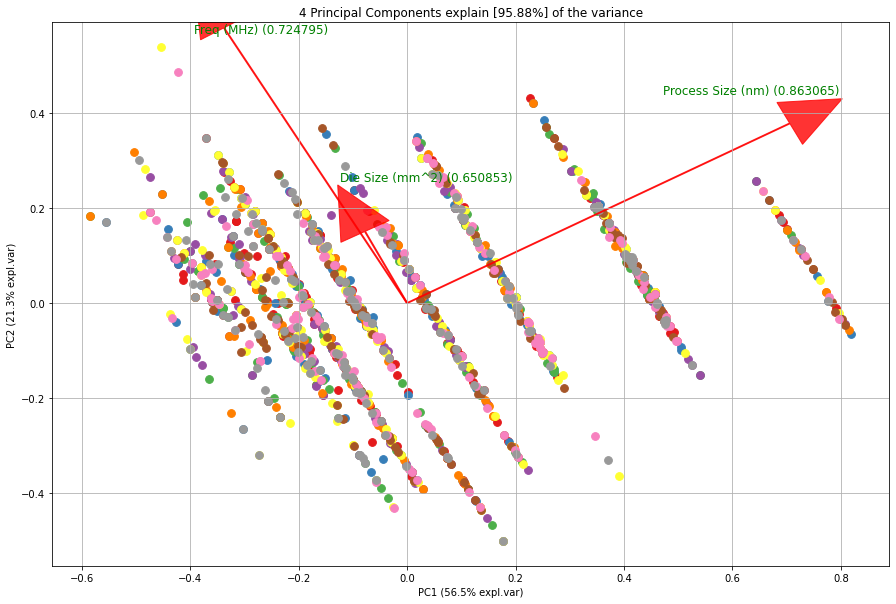

[pca] >Plot PC1 vs PC2 with loadings.
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


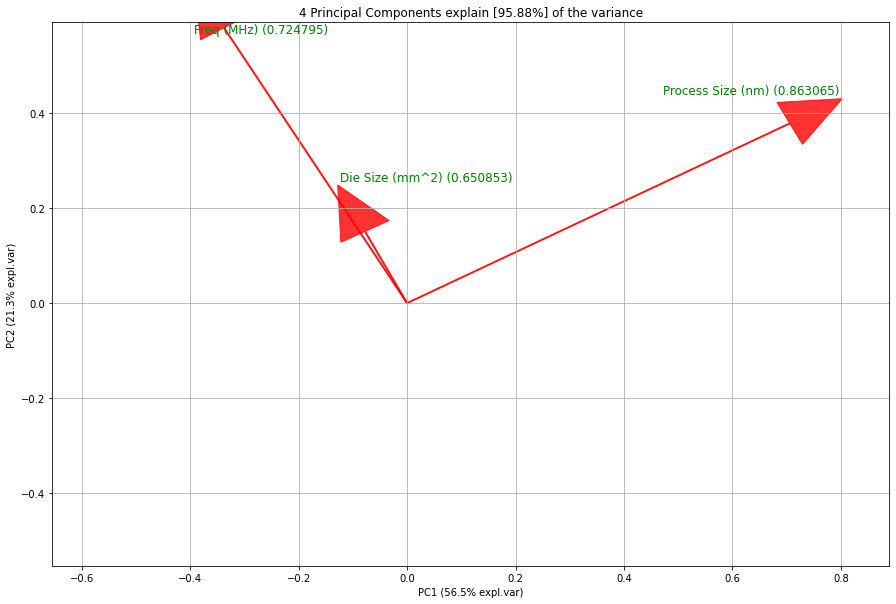

[pca] >Plot PC1 vs PC2 vs PC3 with loadings.
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


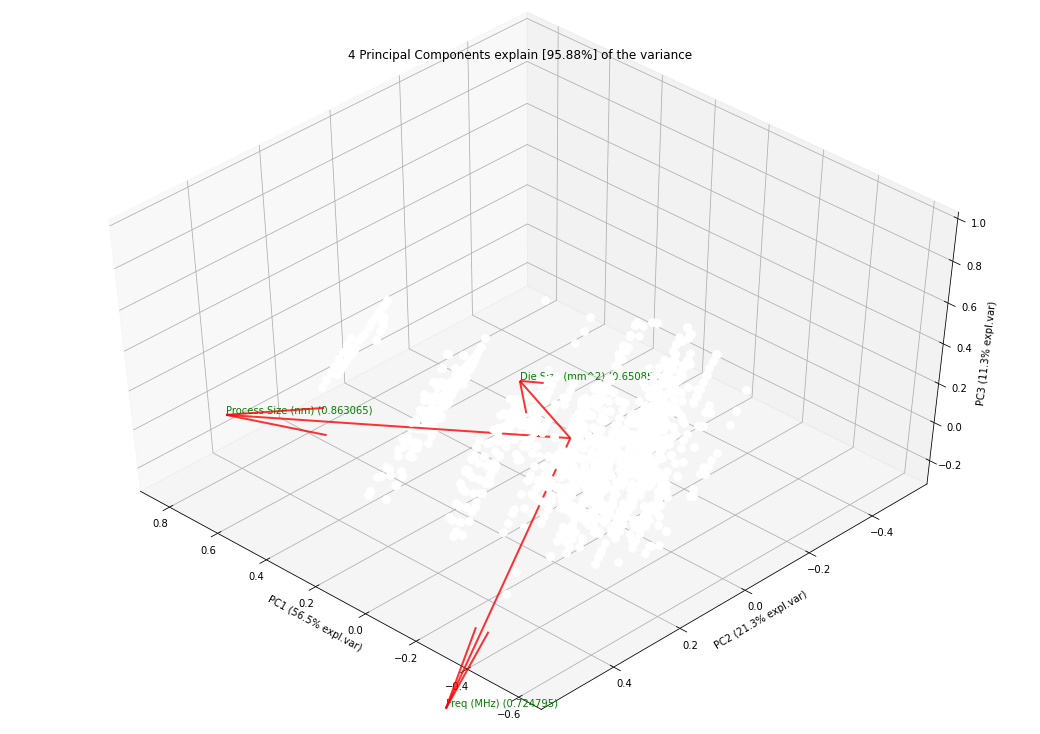

(<Figure size 1080x720 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7ffa83237880>)

In [ ]:
# Initialize
model = pca(normalize=False, n_components=None)
# Fit transform data
results = model.fit_transform(CPU_p)

# Extract the most informative features
results['topfeat']

# Biplot with the loadings
ax = model.biplot(legend=False)
# Biplot with the loadings
ax = model.biplot(n_feat=3, legend=False, label=False)
# Cleaning the biplot by removing the scatter, and looking only at the top 3 features.
ax = model.biplot(n_feat=3, legend=False, label=False, cmap=None)
# Make plot with 3 dimensions
model.biplot3d(n_feat=3, legend=False, label=False, cmap=None)

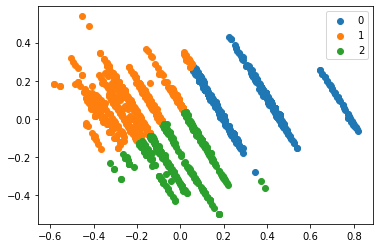

In [ ]:
from sklearn.decomposition import PCA
pca1 = PCA(2)
df = pca1.fit_transform(CPU_p)
df.shape

kmeans = KMeans(n_clusters= 3)
label = kmeans.fit_predict(df)

u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()

#3.3.4 Futher Exploration on the GPU Dataset


In [ ]:
GPU_normal.head()

,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
2192,11.341553,32.0,95.0,216.0,1160.0,100.0,NaN,NaN,NaN
2193,2.568493,150.0,NaN,174.0,80.0,200.0,NaN,NaN,NaN
2194,19.22968,14.0,25.0,132.0,3300.0,1469.0,18.38,1177.0,36.77
2195,8.255479,130.0,NaN,NaN,NaN,200.0,NaN,12.8,NaN
2196,8.832192,55.0,20.0,73.0,242.0,600.0,NaN,96.0,NaN
